In [176]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Code

In [177]:
# read in the data
fake_df = pd.read_csv('fake_data.csv')
# print the tail 
print(fake_df.tail())

      subject cohort  week_num        Mon        Tue        Wed        Thu  \
18318  PD_200     PD        41  15.422691  20.389540  15.746726  20.793219   
18319  PD_200     PD        42  23.690296  20.210504  21.592530  17.348857   
18320  PD_200     PD        43  19.142177  25.329346  20.938469  19.919805   
18321  PD_200     PD        44  16.262621  13.810056  12.148032  16.259669   
18322  PD_200     PD        45  21.284227  14.601011  17.206655  14.034752   

             Fri        Sat        Sun  mean_activity  
18318   9.272010  24.687426  22.093220      18.343547  
18319  18.745112  19.050198  18.771433      19.915561  
18320  21.367710  24.831546  21.268272      21.828189  
18321  16.174192  19.281996  21.967300      16.557695  
18322  19.537480  23.902191  17.281258      18.263939  


In [178]:
# how many observations for each user?
user_counts = fake_df.groupby('subject').size()
print(user_counts)

subject
HC_1      46
HC_10     48
HC_100    46
HC_101    45
HC_102    40
          ..
PD_95     42
PD_96     46
PD_97     42
PD_98     43
PD_99     41
Length: 400, dtype: int64


# Prepare data

In [179]:

# 1. Data Preparation
def prepare_data(df):
    """Convert dataframe to tensors ready for training"""
    # Get unique subjects and split by cohort
    subjects = df['subject'].unique()
    
    # Lists to store our sequences and labels
    all_sequences = []
    all_labels = []
    all_time_points = []
    subject_ids = []
    
    for subject in subjects:
        subject_data = df[df['subject'] == subject].sort_values('week_num')
        features = subject_data[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
        cohort_label = 1 if subject_data['cohort'].iloc[0] == 'PD' else 0
        
        # Only append the full sequences for each unique subject 
        all_sequences.append(features)
        all_labels.append(cohort_label)
        all_time_points.append(len(features))
        subject_ids.append(subject)
    
    return all_sequences, all_labels, all_time_points, subject_ids


In [180]:
# prepare the data
sequences, labels, time_points, subject_ids = prepare_data(fake_df)
# compared to Hemant's code, the ids are not used in the model, but they can be useful for tracking

# Select a batch from the data

In [181]:

# 2. Batch Processing Function
def create_dataloader(sequences, labels, time_points, batch_size=10):
    """Create DataLoader with padded sequences"""
    # Sort by sequence length (for packing)
    sorted_idx = sorted(range(len(sequences)), key=lambda i: len(sequences[i]), reverse=True)
    
    sequences = [sequences[i] for i in sorted_idx]
    labels = [labels[i] for i in sorted_idx]
    time_points = [time_points[i] for i in sorted_idx]
    
    # Get sequence lengths
    lengths = [len(seq) for seq in sequences]
    
    # Pad sequences
    max_len = max(lengths)
    padded_sequences = []
    
    # post padding: adding weeks of zeros to the end of the sequence
    # to make all sequences the same length of the longest sequence (52)
    for seq in sequences:
        padded_seq = np.zeros((max_len, seq.shape[1]))
        padded_seq[:len(seq)] = seq
        padded_sequences.append(padded_seq)
    
    # Convert to tensors
    X = torch.FloatTensor(padded_sequences)
    y = torch.FloatTensor(labels)
    # lengths should be a tensor from 1 to 52, evenly spaced 
    t_s = range(1, max_len + 1) 
    lengths = torch.FloatTensor(t_s) 
    time_weights = torch.FloatTensor(time_points)

    # To match Hemant's code, transpose the data
    X = X.transpose(0, 1)  # (num_weeks, num_subjects, num_features)
    
    # Create TensorDataset and DataLoader
    # dataset = TensorDataset(X, lengths, y, time_weights)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # return dataloader
    return X, lengths, y, time_weights



In [182]:
# observe the tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# print the shapes
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)

X shape: torch.Size([52, 400, 7])
Labels shape: torch.Size([400])
Lengths shape: torch.Size([52])


In his code, each subject is observed at 100 evenly spaced time points. His 100 observations are akin to 100 weeks of observations in our case. ie 100 consecutive measurements where each contains a full week's worth of data. 

In our fake data, the maximum length of weekly observations is 52. After padding, each subject should have 52 weeks of data, which should be the first dimension of the x tensor. This means that each subject has 52 observations, with some of them being padded with zeros.

The number of subjects should also be 400, with 200 subjects in each group. This should be the second dimension of the x tensor.

The last dimension of the x tensor should be 7, which is the number of features.

REVISIT LATER TO IMPLEMENT DATALOADER

1.0


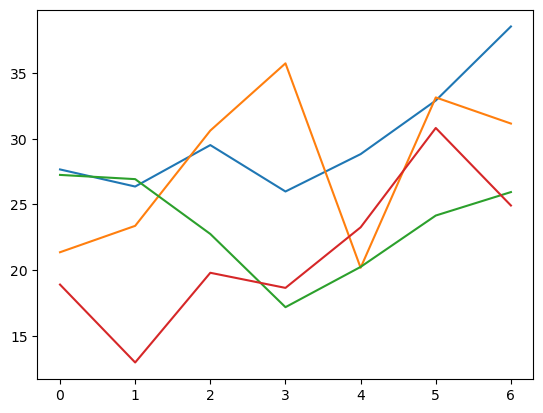

In [183]:
print(y[399].item())
# visualize the activity for the last subject, a PD subject 
tmp = X[:,399,:].detach().numpy()
for i in range(0, 52, 13):
    plt.plot(tmp[i,:])
plt.show()

In [184]:
# Function to get random batches for stochastic optimization
def get_batch(x_data, y_data,batch_size):
    n_sequences = x_data.size(1)
    # Randomly select indices for the batch
    batch_indices = torch.randperm(n_sequences)[:batch_size]
    # Sample the batch
    x_batch = x_data[:, batch_indices, :]
    y_batch = y_data[batch_indices]
    return x_batch,y_batch, batch_indices

# Create LSTM 

In [185]:
# 3. LSTM Model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.lin = nn.Linear(hidden_size, output_size) 

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        # apply linear layer to each time step 
        weight = self.lin(lstm_out)
        # denominator to normalize the weights 
        epsilon = 1e-6
        weight_denom = torch.sum(torch.abs(weight), axis=2) + epsilon
        # normalize the weights
        # torch.mul is the element-wise multiplication
        output = torch.sum(torch.mul(weight, x), axis=2) / weight_denom
        return output, weight

In [186]:
# 4. Separation Loss
def loss_fn(output, weight, labels, time_weights):
    y1_idx = torch.nonzero(labels > 0.5).flatten()
    y0_idx = torch.nonzero(labels < 0.5).flatten()

    epsilon = 1e-6
    y1_sum = torch.sum(output[:, y1_idx], axis=1) / (torch.numel(y1_idx) + epsilon) # numel is the number of elements in the tensor
    y1_sum = y1_sum*(1+time_weights)
    y1_sum = torch.sum(y1_sum)

    y0_sum = torch.sum(output[:, y0_idx], axis=1) / (torch.numel(y0_idx) + epsilon)
    y0_sum = torch.sum(y0_sum)

    w_std = torch.std(weight.flatten())

    # the weight is multiplied by a factor of 20 to make it more significant
    return -y1_sum + y0_sum + 20.0*w_std


# Training

In [187]:
input_size = 7 
hidden_size = 20
output_size = 7
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

In [201]:
# 5. Training Loop
def train_model(model, X, lengths, y, num_epochs=300, batch_size=50, lr=0.0003):
    """Train the LSTM model"""

    # debugging statements
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"lengths shape: {lengths.shape}")
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()

        # Get a random batch
        x_batch, y_batch, batch_indices = get_batch(X, y, batch_size)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output, weight = model(x_batch)
        
        # Compute loss
        loss = loss_fn(output, weight, y_batch, lengths)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [189]:
# train the model 
train_model(model, X, lengths, y, num_epochs=10000, batch_size=50, lr=0.0003)

X shape: torch.Size([52, 400, 7])
y shape: torch.Size([400])
lengths shape: torch.Size([52])
Epoch [10/10000], Loss: -15977.3301
Epoch [20/10000], Loss: -22671.0000
Epoch [30/10000], Loss: -23217.5273
Epoch [40/10000], Loss: -23233.4863
Epoch [50/10000], Loss: -23575.6777
Epoch [60/10000], Loss: -24074.7656
Epoch [70/10000], Loss: -24107.3066
Epoch [80/10000], Loss: -23734.5117
Epoch [90/10000], Loss: -24477.6934
Epoch [100/10000], Loss: -23982.3887
Epoch [110/10000], Loss: -24752.0840
Epoch [120/10000], Loss: -24234.6211
Epoch [130/10000], Loss: -24811.5957
Epoch [140/10000], Loss: -25308.8145
Epoch [150/10000], Loss: -24959.7832
Epoch [160/10000], Loss: -25180.6562
Epoch [170/10000], Loss: -25843.9258
Epoch [180/10000], Loss: -26103.5039
Epoch [190/10000], Loss: -26594.5625
Epoch [200/10000], Loss: -27514.1074
Epoch [210/10000], Loss: -27774.2266
Epoch [220/10000], Loss: -27956.3711
Epoch [230/10000], Loss: -27891.4648
Epoch [240/10000], Loss: -26883.8398
Epoch [250/10000], Loss: -27

torch.Size([52, 400])


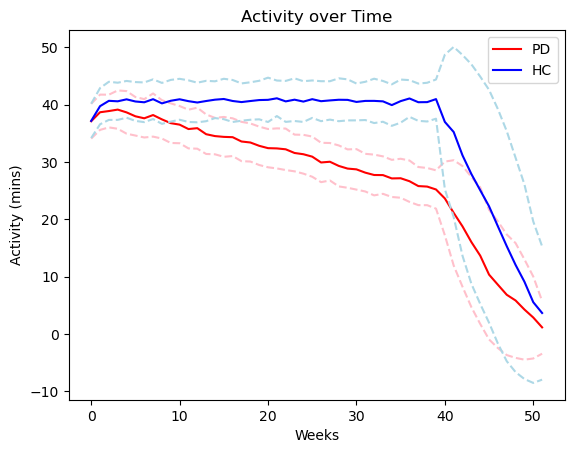

6.6011395


In [190]:
# plotting

output,weight=model(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='red', label='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='--')
plt.plot(output_mean-output_std, color='pink', linestyle='--')

y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label='HC')
plt.plot(output_mean+output_std, color='lightblue', linestyle='--')
plt.plot(output_mean-output_std, color='lightblue', linestyle='--')
plt.xlabel('Weeks')
plt.ylabel('Activity (mins)')
plt.title('Activity over Time')
plt.legend()
plt.show()

print(np.mean(output_std))

The way I generated fake data, all subjects have between 40 to 52 weeks of ambulatory data. All subjets that have less than the maximum number of weeks of data (52) are padded with zeros at the end. This is evident in the graph above. It seems like up until week 40, it's fairly stable and there seems to be good separation between the two groups. After week 40, the two groups start to converge and the separation is not as clear. 

So, in summary, the 0s are affecting the model's ability to learn from the data.

I read that the LSTM model is able to mask data, but must still be trained with the same lengthed data. So when it comes to real data, I can zero pad and then use masks to ignore weeks with 0s. Hopefully, this way, the model only learns from relevant weeks with data. 

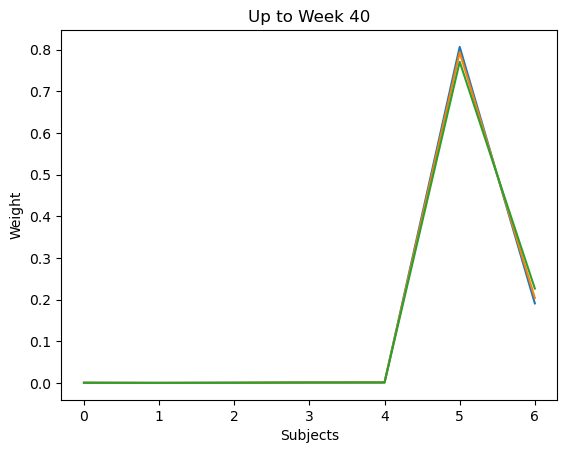

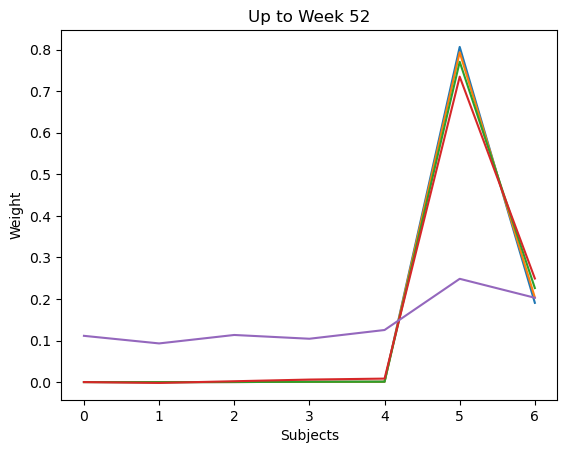

In [191]:
w = torch.mean(weight, axis=1)

for i in range(10,40,10):
    tmp=w[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 40")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

for i in range(10,52,10):
    tmp=w[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 52")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

The above aligns with how I generated data. I made weekdays consistent while varying weekend activity with Saturday being the most active day.

# to dos 
- Add a dataloader
- generatte progression indices 
- visualize the separation of the two groups

In [ ]:

# 5. Training function using dataloader REVISIT
def train_model_loader(model, dataloader, optimizer, num_epochs=50):
    model.train()
    
    # Track metrics
    history = {
        'loss': [],
        'pd_mean': [],
        'hc_mean': [],
        'separation': []
    }
    
    # Add MSE loss for regularization
    mse_loss = nn.MSELoss()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        all_outputs = []
        all_labels = []
        
        for batch_idx, (sequences, lengths, labels, time_weights) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences, lengths)
            
            # Store for metrics calculation
            all_outputs.append(outputs.detach())
            all_labels.append(labels)
            
            # Primary loss: separation between PD and HC
            sep_loss = separation_loss(outputs, labels)
            
            # Add regularization: push PD outputs higher (closer to 1) and HC outputs lower (closer to 0)
            # This ensures non-zero initialization
            target_values = labels.clone()
            reg_loss = mse_loss(outputs, target_values)
            
            # Combined loss with regularization
            combined_loss = sep_loss + 0.1 * reg_loss
            
            # Apply time weighting - later timepoints matter more
            time_weight_factor = 1.0 + torch.log1p(time_weights) / 10.0
            weighted_loss = combined_loss * torch.mean(time_weight_factor)
            
            # Backward pass
            weighted_loss.backward()
            optimizer.step()
            
            epoch_loss += weighted_loss.item()
        
        # Calculate metrics for this epoch
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)
        
        pd_mask = (all_labels == 1).squeeze()
        hc_mask = (all_labels == 0).squeeze()
        
        # Ensure we have samples from both groups before calculating means
        if pd_mask.any() and hc_mask.any():
            pd_mean = torch.mean(all_outputs[pd_mask]).item()
            hc_mean = torch.mean(all_outputs[hc_mask]).item()
            separation = pd_mean - hc_mean
        else:
            pd_mean = 0
            hc_mean = 0
            separation = 0
        
        # Save metrics
        history['loss'].append(epoch_loss / len(dataloader))
        history['pd_mean'].append(pd_mean)
        history['hc_mean'].append(hc_mean)
        history['separation'].append(separation)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {history["loss"][-1]:.4f}, ' +
                  f'PD: {pd_mean:.4f}, HC: {hc_mean:.4f}, Separation: {separation:.4f}')
    
    return model, history


# Try the model above on enhanced fake data 

In [193]:
enhanced_data = pd.read_csv('enhanced_fake_data.csv')
print(enhanced_data.tail())

      subject cohort       subgroup  week_num        date  month        Mon  \
18413  PD_200     PD  rapid_decline        43  2023-10-22     10  12.180682   
18414  PD_200     PD  rapid_decline        44  2023-10-29     10   6.318736   
18415  PD_200     PD  rapid_decline        45  2023-11-05     11  10.969956   
18416  PD_200     PD  rapid_decline        46  2023-11-12     11   7.031633   
18417  PD_200     PD  rapid_decline        47  2023-11-19     11   6.020245   

             Tue        Wed       Thu        Fri        Sat       Sun  \
18413   3.205703   6.434392  8.717928   7.071271  11.867912  8.544214   
18414   7.682095   1.918044  6.826817   6.494815  10.577110  8.873641   
18415  11.193979  10.420175  5.953746  11.710343   5.218916  6.116481   
18416  10.482157   9.270316  8.992806   5.044355   8.898817  4.227659   
18417   8.038012   2.471093  9.579829  10.492384   8.709737  8.410412   

      decline_type  weekly_avg  
18413  exponential    8.288872  
18414  exponential  

In [202]:
# Prep the data
sequences, labels, time_points, subject_ids = prepare_data(enhanced_data)

# Create tensors
X, lengths, y, time_weights = create_dataloader(sequences, labels, time_points, batch_size=10)
# verify shapes 
print("X shape:", X.shape)
print("Labels shape:", y.shape)
print("Lengths shape:", lengths.shape)

# training 
# params 
input_size = 7
hidden_size = 20
output_size = 7
num_layers = 2
# Create the model
model2 = LSTMModel(input_size, hidden_size, output_size, num_layers)
train_model(model2, X, lengths, y, num_epochs=50000)


X shape: torch.Size([52, 400, 7])
Labels shape: torch.Size([400])
Lengths shape: torch.Size([52])
X shape: torch.Size([52, 400, 7])
y shape: torch.Size([400])
lengths shape: torch.Size([52])
Epoch [10/50000], Loss: -6512.0605
Epoch [20/50000], Loss: -12401.3838
Epoch [30/50000], Loss: -15321.2939
Epoch [40/50000], Loss: -17469.2559
Epoch [50/50000], Loss: -17548.5000
Epoch [60/50000], Loss: -18009.3770
Epoch [70/50000], Loss: -18824.5859
Epoch [80/50000], Loss: -16897.7285
Epoch [90/50000], Loss: -14719.4287
Epoch [100/50000], Loss: -17787.3730
Epoch [110/50000], Loss: -15608.6504
Epoch [120/50000], Loss: -17200.3652
Epoch [130/50000], Loss: -14861.9531
Epoch [140/50000], Loss: -16619.4082
Epoch [150/50000], Loss: -19390.8770
Epoch [160/50000], Loss: -18786.1719
Epoch [170/50000], Loss: -19987.2461
Epoch [180/50000], Loss: -20849.0996
Epoch [190/50000], Loss: -16922.6543
Epoch [200/50000], Loss: -19053.6348
Epoch [210/50000], Loss: -18483.2168
Epoch [220/50000], Loss: -15827.3828
Epoch

torch.Size([52, 400])


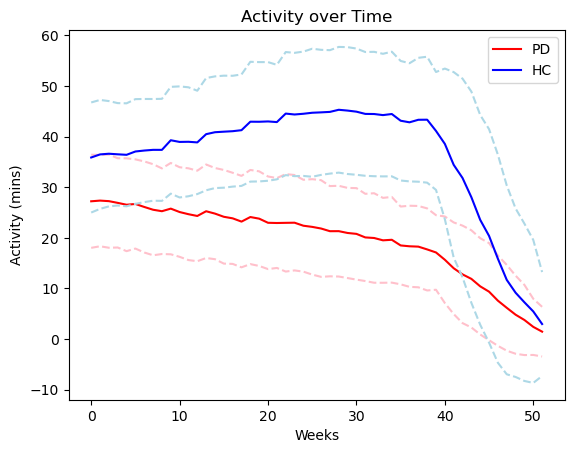

12.85341


In [203]:
# plotting 
output,weight=model2(X)
print(output.shape)
y1_index=torch.nonzero(y>0.5).flatten()
out=output[:,y1_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
# specify colors 
plt.plot(output_mean, color='red', label ='PD')
plt.plot(output_mean+output_std, color='pink', linestyle='dashed')
plt.plot(output_mean-output_std, color ='pink', linestyle='dashed')

y0_index=torch.nonzero(y<=0.5).flatten()
out=output[:,y0_index]
output_np=out.detach().numpy()
output_mean=np.mean(output_np,axis=1)
output_std=np.std(output_np,axis=1)
plt.plot(output_mean, color='blue', label ='HC')
plt.plot(output_mean+output_std, color='lightblue', linestyle='dashed')
plt.plot(output_mean-output_std, color ='lightblue', linestyle='dashed')
plt.xlabel('Weeks')
plt.ylabel('Activity (mins)')
plt.title('Activity over Time')
plt.legend()
plt.show()
print(np.mean(output_std))

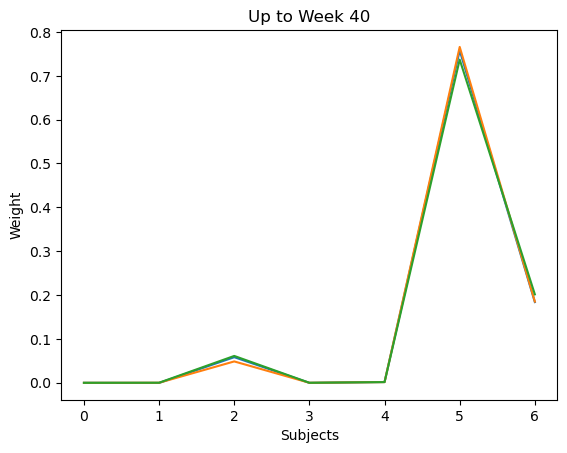

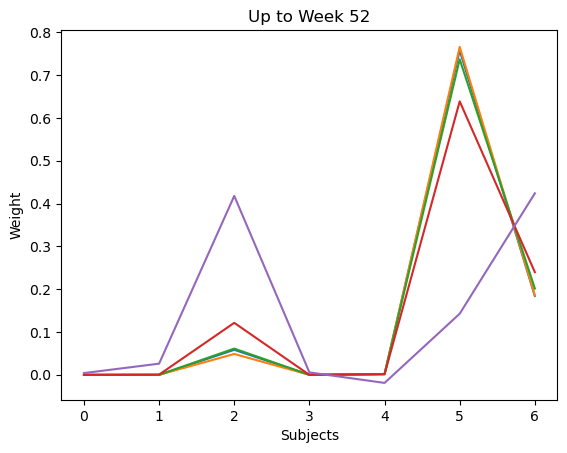

In [205]:
w2 = torch.mean(weight, axis=1)
for i in range(10,40,10):
    tmp=w2[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 40")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()

for i in range(10,52,10):
    tmp=w2[i,:].detach().numpy()
    tmp=tmp/np.sum(tmp)
    plt.plot(tmp)
    # labels
    plt.title("Up to Week 52")
    plt.xlabel("Subjects")
    plt.ylabel("Weight")
plt.show()